In [2]:
from lib_all import *
import nbimporter
from data.path import get_path
from data.dataset import MyDataset, collate_fn
from data.processing_data import DataTransform
from data.info_annotation import InfoAnno
from sourc_code.model.model import SSD
from sourc_code.model.multibox_loss import MultiBoxLoss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
torch.backends.cudnn.benchmark = True

In [4]:
# dataloader
root_path ='../../data/data_set/VOCdevkit/VOC2012'
train_img_list, train_anno_list, val_img_list, val_anno_list = get_path(root_path)

classes = ["aeroplane", "bicycle", "bird",  "boat", "bottle",
           "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant",
           "sheep", "sofa", "train", "tvmonitor"]

color_mean = (104, 117, 123)
input_size = 300

#img_list, anno_list, phase, transform, anno_xml
train_dataset = MyDataset(train_img_list, train_anno_list, phase="train", DataTransform=DataTransform(input_size, color_mean), InfoAnno=InfoAnno(classes))
val_dataset = MyDataset(val_img_list, val_anno_list, phase="val", DataTransform=DataTransform(input_size, color_mean), InfoAnno=InfoAnno(classes))

batch_size = 12



train_dataloader = data.DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = data.DataLoader(val_dataset, batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

# network
cfg = {
    "num_classes": 21, #VOC data include 20 class + 1 background class
    "input_size": 300, #SSD300
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4], # Tỷ lệ khung hình cho source1->source6`
    "feature_maps": [38, 19, 10, 5, 3, 1],
    "steps": [8, 16, 32, 64, 100, 300], # Size of default box
    "min_size": [30, 60, 111, 162, 213, 264], # Size of default box
    "max_size": [60, 111, 162, 213, 264, 315], # Size of default box
    "aspect_ratios": [[2], [2,3], [2,3], [2,3], [2], [2]]
}

net = SSD(phase="train", cfg=cfg)
vgg_weights = torch.load("../../data/weights/vgg16_reducedfc.pth")
net.vgg.load_state_dict(vgg_weights)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# He init
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# MultiBoxLoss
criterion = MultiBoxLoss(jaccard_threshold=0.5, neg_pos=3, device=device)

# optimizer
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

# training, validation
def train_model(net, dataloader_dict, criterion, optimizer, num_epochs):
    # move network to GPU
    net.to(device)

    iteration = 1
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    logs = []
    for epoch in range(num_epochs+1):
        t_epoch_start = time.time()
        t_iter_start = time.time()
        print("---"*20)
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("---"*20)
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
                print("(Training)")
            else:
                if (epoch+1) % 10 == 0:
                    net.eval()
                    print("---"*10)
                    print("(Validation)")
                else:
                    continue
            for images, targets in dataloader_dict[phase]:
                # move to GPU
                images = images.to(device)
                targets = [ann.to(device) for ann in targets]
                # init optimizer
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase=="train"):
                    outputs = net(images)
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    if phase == "train":
                        loss.backward() # calculate gradient
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                        optimizer.step() # update parameters

                        if (iteration % 10) == 0:
                            t_iter_end = time.time()
                            duration = t_iter_end - t_iter_start
                            print("Iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec".format(iteration, loss.item(), duration))
                            t_iter_start = time.time()
                        epoch_train_loss += loss.item()
                        iteration += 1
                    else:
                        epoch_val_loss += loss.item()
        t_epoch_end = time.time()
        print("---"*20)
        print("Epoch {} || epoch_train_loss: {:.4f} || Epoch_val_loss: {:.4f}".format(epoch+1, epoch_train_loss, epoch_val_loss))
        print("Duration: {:.4f} sec".format(t_epoch_end - t_epoch_start))
        t_epoch_start = time.time()

        log_epoch = {"epoch": epoch + 1, "train_loss": epoch_train_loss, "val_loss": epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("../../data/weights/ssd_optimize.csv")
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), "../../data/weights/ssd300_" + str(epoch+1) + ".pth")

num_epochs = 10
train_model(net, dataloader_dict, criterion, optimizer, num_epochs=num_epochs)

device: cuda:0
------------------------------------------------------------
Epoch 1/3
------------------------------------------------------------
(Training)
Iteration 10 || Loss: 18.9073 || 10iter: 17.3233 sec
Iteration 20 || Loss: 16.9618 || 10iter: 11.6997 sec
Iteration 30 || Loss: 15.2749 || 10iter: 12.7054 sec
Iteration 40 || Loss: 15.8458 || 10iter: 12.6434 sec


KeyboardInterrupt: 

<AxesSubplot:>

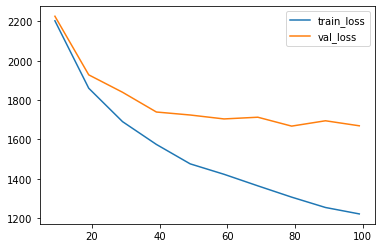

In [3]:
loss = pd.read_csv("../../data/history_train/ssd_logs.csv")
df2 = loss[loss['val_loss'] != 0]
df2[['train_loss', 'val_loss']].plot()

<AxesSubplot:>

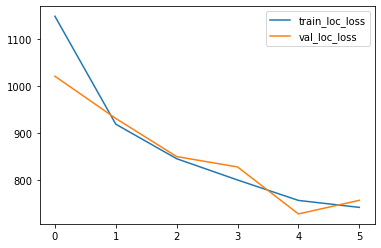

In [8]:
df = pd.read_csv("../../data/history_train/optimaze.csv")
df[['train_loc_loss','val_loc_loss']].plot()

<AxesSubplot:>

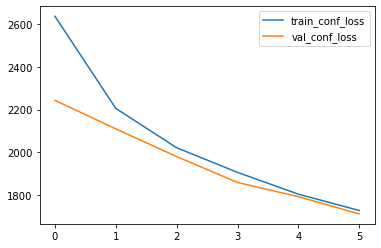

In [9]:
df = pd.read_csv("../../data/history_train/optimaze.csv")
df[['train_conf_loss','val_conf_loss']].plot()

<AxesSubplot:>

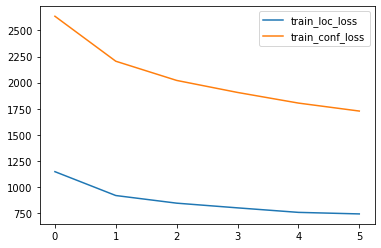

In [10]:
df = pd.read_csv("../../data/history_train/optimaze.csv")
df[['train_loc_loss','train_conf_loss']].plot()

<AxesSubplot:>

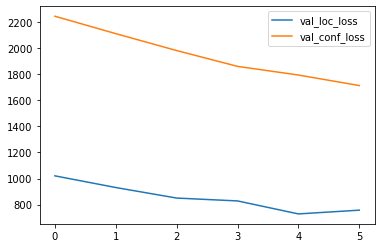

In [11]:
df = pd.read_csv("../../data/history_train/optimaze.csv")
df[['val_loc_loss','val_conf_loss']].plot()